In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Изучить особенности данных:
### Рассчитать основные статистики для вещественных и категориальных признаков (df.describe(include=’all’))


In [20]:
# Загрузка таргет-таблицы и дескрипторов

multi_target_path = r"../ml/hse/yp/27_toxicity_prediction/formatted_data/features/multi_target_cleaned.csv"
multi_target_df = pd.read_csv(multi_target_path)
desc_path = r"../Desktop/smiles_physchem_descriptors.csv"
desc_df = pd.read_csv(desc_path)
# Объединяем по smiles
merged_df = multi_target_df.merge(desc_df, on='smiles', how='inner')

# Посчитаем абсолютную корреляцию каждого физико-химического признака с каждой категорией токсичности
# Отберём только те признаки, которые хотя бы с одной категорией имеют |r| > 0.1
# Посчитаем, сколько таких признаков оказалось

descriptor_cols = desc_df.columns.drop('smiles')
target_cols = multi_target_df.columns.drop('smiles')
# Корреляция дескрипторов с категориями
corr_df = pd.DataFrame({cat: merged_df[descriptor_cols].corrwith(merged_df[cat].fillna(0)) 
                        for cat in target_cols})
# Отбираем признаки с |r| > 0.1 хотя бы с одной категорией
threshold = 0.1
informative_features = corr_df[(corr_df.abs() > threshold).any(axis=1)].index.tolist()
print(f"Количество признаков с |r| > {threshold} с любой категорией: {len(informative_features)}")


Количество признаков с |r| > 0.1 с любой категорией: 57


In [21]:
# Проверка попарной корреляции между признаками
informative_df = merged_df[informative_features]
corr_matrix = informative_df.corr().abs()

# Убираем сильно коррелированные (r > 0.9)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.9)]
final_features = [f for f in informative_features if f not in to_drop]
print(f"Количество признаков после удаления сильно коррелированных: {len(final_features)}")

# Финальный датасет с multi-target и выбранными признаками
final_df = merged_df[['smiles'] + final_features + list(target_cols)]
print("Форма финального датасета:", final_df.shape)

# Финальный датафрейм только с признаками для eda-анализа
eda_features_df = merged_df[final_features].copy()

Количество признаков после удаления сильно коррелированных: 36
Форма финального датасета: (339055, 58)


In [22]:
eda_features_df.describe()

,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BalabanJ,BertzCT,Chi0,EState_VSA1,EState_VSA11,EState_VSA4,EState_VSA8,HallKierAlpha,...,RingCount,SMR_VSA3,SMR_VSA5,SMR_VSA6,SMR_VSA7,SlogP_VSA2,TPSA,VSA_EState3,VSA_EState6,VSA_EState8
count,338784.000000,338784.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,...,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000,339055.000000
mean,2.269840,-2.301294,1.868849,836.361179,17.846583,8.533532,0.018770,19.254314,16.059991,-2.486352,...,3.001994,9.775909,22.673410,16.905323,52.734847,34.191216,73.956423,7.206296,10.442623,2.893821
std,0.116467,0.176970,0.434238,317.254396,4.967071,13.772820,0.981460,15.459882,14.170619,0.925681,...,1.107705,7.370204,19.297141,14.190468,22.006446,19.818623,36.154196,7.704173,5.782872,2.782316
min,-2.996000,-3.668805,-0.000008,0.000000,0.000000,0.000000,0.000000,-0.061902,0.000000,-50.180000,...,0.000000,0.000000,-2.558086,0.000000,0.000000,-2.558086,0.000000,-17.939047,-106.849663,-128.294945
25%,2.203750,-2.425489,1.586907,641.866856,14.982763,0.000000,0.000000,6.066367,5.316789,-3.060000,...,2.000000,4.899910,9.496092,5.752854,35.895287,20.888462,54.020000,2.693804,6.488608,0.534013
50%,2.266725,-2.319628,1.796616,825.292917,17.742276,5.907180,0.000000,16.720788,11.053200,-2.500000,...,3.000000,9.799819,19.262465,13.089513,53.603279,31.191348,71.950000,5.126898,10.099670,2.237020
75%,2.328644,-2.185444,2.060465,1017.819273,20.543241,11.887211,0.000000,28.118077,20.842241,-1.920000,...,4.000000,14.764463,32.104108,25.516099,65.724207,44.625001,90.980000,10.850193,14.230724,4.358464
max,3.125698,0.885700,8.210941,25876.351133,365.893776,1345.578646,258.905008,198.054278,419.699944,4.260000,...,46.000000,364.360606,919.778993,421.378266,455.226856,1189.935526,3107.120000,382.061423,54.724517,46.733652


In [23]:
# NA анализ
eda_features_df.isnull().sum().sort_values(ascending=False) 

BCUT2D_LOGPHI                      271
BCUT2D_LOGPLOW                     271
NumSaturatedHeterocycles             0
NumSaturatedRings                    0
NumUnspecifiedAtomStereoCenters      0
PEOE_VSA1                            0
PEOE_VSA7                            0
PEOE_VSA8                            0
RingCount                            0
SMR_VSA3                             0
SMR_VSA5                             0
SMR_VSA6                             0
SMR_VSA7                             0
SlogP_VSA2                           0
TPSA                                 0
VSA_EState3                          0
VSA_EState6                          0
NumRotatableBonds                    0
NumHeterocycles                      0
NumHeteroatoms                       0
EState_VSA8                          0
BalabanJ                             0
BertzCT                              0
Chi0                                 0
EState_VSA1                          0
EState_VSA11             

### Есть ли пропущенные значения. Сколько. Какова их доля от общего числа объектов для каждого конкретного признака. И, в целом, насколько ваш датасет “разрежен” в контексте пропущенных значений. Выдвинуть и (желательно) проверить гипотезу, что могут означать пропущенные значения? Осмысленно и аргументированно обработать пропуски.

BCUT2D_LOGPHI, BCUT2D_LOGPLOW - 271 пропуск (Статистические индексы на основе матрицы расстояний и свойств атомов) - 0.08%.
Пропуски могли возникнуть из-за ошибок парсинга молекул или нестрандартной структуры smiles. 
Заполнение медианой не искажает сильно распределение, потому что пропусков очень мало и это стандартная практика в QSAR / токсичности.

In [24]:
# Список признаков с NaN
features_with_nan = eda_features_df.columns[eda_features_df.isnull().any()].tolist()
print("Признаки с пропусками:", features_with_nan)
# Заполняем медианой
for feat in features_with_nan:
    median_value = eda_features_df[feat].median()
    eda_features_df[feat] = eda_features_df[feat].fillna(median_value)
    print(f"{feat}: заполнили медианой = {median_value}")

# Проверяем, что пропусков больше нет
print("\nКоличество пропусков после заполнения:")
print(eda_features_df.isnull().sum().sum())

Признаки с пропусками: ['BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW']
BCUT2D_LOGPHI: заполнили медианой = 2.2667250373250516
BCUT2D_LOGPLOW: заполнили медианой = -2.3196276441922734

Количество пропусков после заполнения:
0


### Есть ли ошибочные  (например, отрицательный возраст или пятиметровый рост человека; 3-й класс в задаче бинарной классификации) значения (признаки, целевая переменная) в данных. Обработать их.


In [25]:
# Среди десксриптеров есть счетчики. Проверим на отрицательные значения
counters = [i for i in eda_features_df.columns if 'Num' in i or 'Count' in i]
(eda_features_df[counters] < 0).sum().sort_values(ascending=False)
# отрицательный счетчиков нет

NumAliphaticHeterocycles           0
NumAliphaticRings                  0
NumAromaticRings                   0
NumAtomStereoCenters               0
NumHAcceptors                      0
NumHDonors                         0
NumHeteroatoms                     0
NumHeterocycles                    0
NumRotatableBonds                  0
NumSaturatedHeterocycles           0
NumSaturatedRings                  0
NumUnspecifiedAtomStereoCenters    0
RingCount                          0
dtype: int64

In [26]:
# Среди десксриптеров есть весовые характеристики. Проверим на отрицательные значения
# 'TPSA' - полярная поверхность
mass = ['TPSA']
(eda_features_df[mass] < 0).sum().sort_values(ascending=False)
# отрицательный счетчиков нет
# все остальные харакетеристики могут принимать различные значения

TPSA    0
dtype: int64

### Есть ли выбросы в данных? По возможности обработать их. Изучить поведение каждого признака в отдельности, его связь с целевой переменной, а также попарные корреляции (в т.ч и в особенности с таргетом). Визуализировать попарные распределения признаков (sns.pairplot()) и корреляции наиболее значимых. Построить подходящие сводные таблицы и прочие диаграммы.
Выбросы в колонках с кол-вом акцепторов, доноров, аминных соединений, ароматичсеких колец и тд. NumAtomStereoCenters, NumHAcceptors, NumHDonors, NumAliphaticRings имеют сильный сдвиг к нулю, большинство молекул имеют маленькие значения, что характерно для дискретных топологических и структурных признаков. TPSA, MolLogP, EState_VSA*, SMR_VSA* имеют правосторонние длинные хвосты, т.е. распределение асимметричное, что типично для электростатических дескрипторов. Некоторые признаки имеют плотные пики на нуле, многие химические структуры не имеют специфических групп или свойств, из-за чего дескриптор равен 0 NumSaturatedRings, NumHeterocycles, NumRotatableBonds. BertzCT, Chi0, TPSA имеют экстремальные значения, что вполне отвечает реальным значениям больших химических в-в.


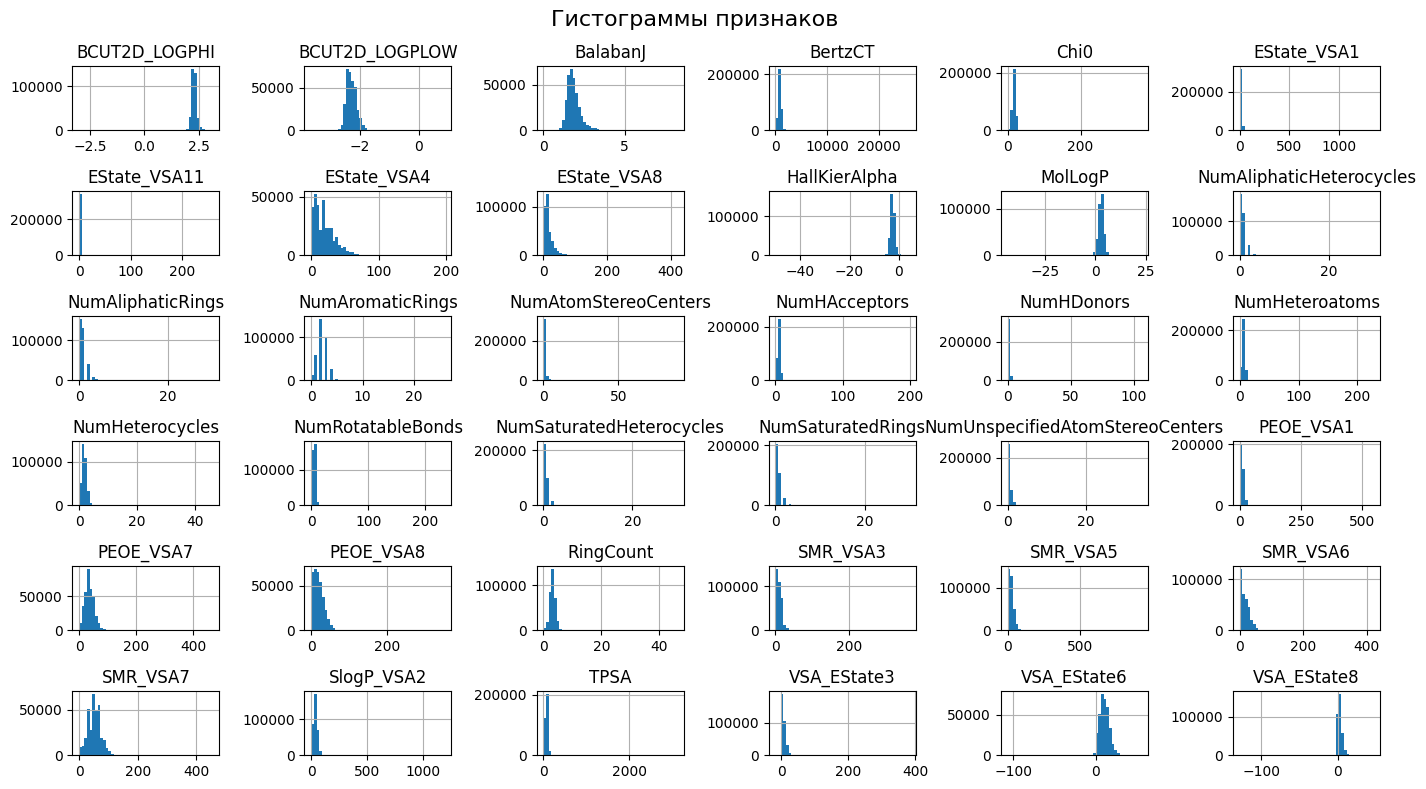

In [27]:
import matplotlib.pyplot as plt
# Гистограммы признаков
df_to_plot = eda_features_df[final_features]  df_to_plot.hist(bins=50, figsize=(14, 8))
plt.suptitle("Гистограммы признаков", fontsize=16)
plt.tight_layout()
plt.show()

In [28]:
# Физико-химические дескрипторы редко показывают очень высокую корреляцию с бинарным таргетом.
# Значения корреляции 0.05–0.2 считаются адекватными и реальными для таких данных, высокие значения (>0.5) обычно малореалистичны.
# То есть максимальная корреляция в наших данных не превышает норму адекватности, и всё выглядит логично.
# Дальше смотреть все остальные корреляции по категориям уже мало смысла, потому что они все низкие, но достаточно значимые, чтобы использовать в анализе.
# Главное, что у каждой категории есть несколько признаков с относительно максимальной корреляцией, на основе которых можно строить модели.

# Корреляция признаков с таргетами
corr_with_target = pd.DataFrame({
    cat: eda_features_df.corrwith(multi_target_df[cat].fillna(0))
    for cat in target_cols})
# Для каждой категории находим признак с максимальной по модулю корреляцией
top_corr_per_category = pd.DataFrame({
    'top_feature': corr_with_target.abs().idxmax(),
    'correlation': corr_with_target.abs().max()})
top_corr_per_category['correlation'] = top_corr_per_category['correlation'].round(3)
display(top_corr_per_category)

,top_feature,correlation
acute_toxicity,NumAtomStereoCenters,0.138
carcinogenicity,NumAtomStereoCenters,0.073
cardiotoxicity,EState_VSA4,0.220
dermal_toxicity,NumAtomStereoCenters,0.122
developmental_toxicity,BCUT2D_LOGPHI,0.055
endocrine_disruption,NumAtomStereoCenters,0.091
gastrointestinal_toxicity,NumAtomStereoCenters,0.147
genotoxicity,BalabanJ,0.169
hematotoxicity,NumAtomStereoCenters,0.100
hepatotoxicity,NumAtomStereoCenters,0.129


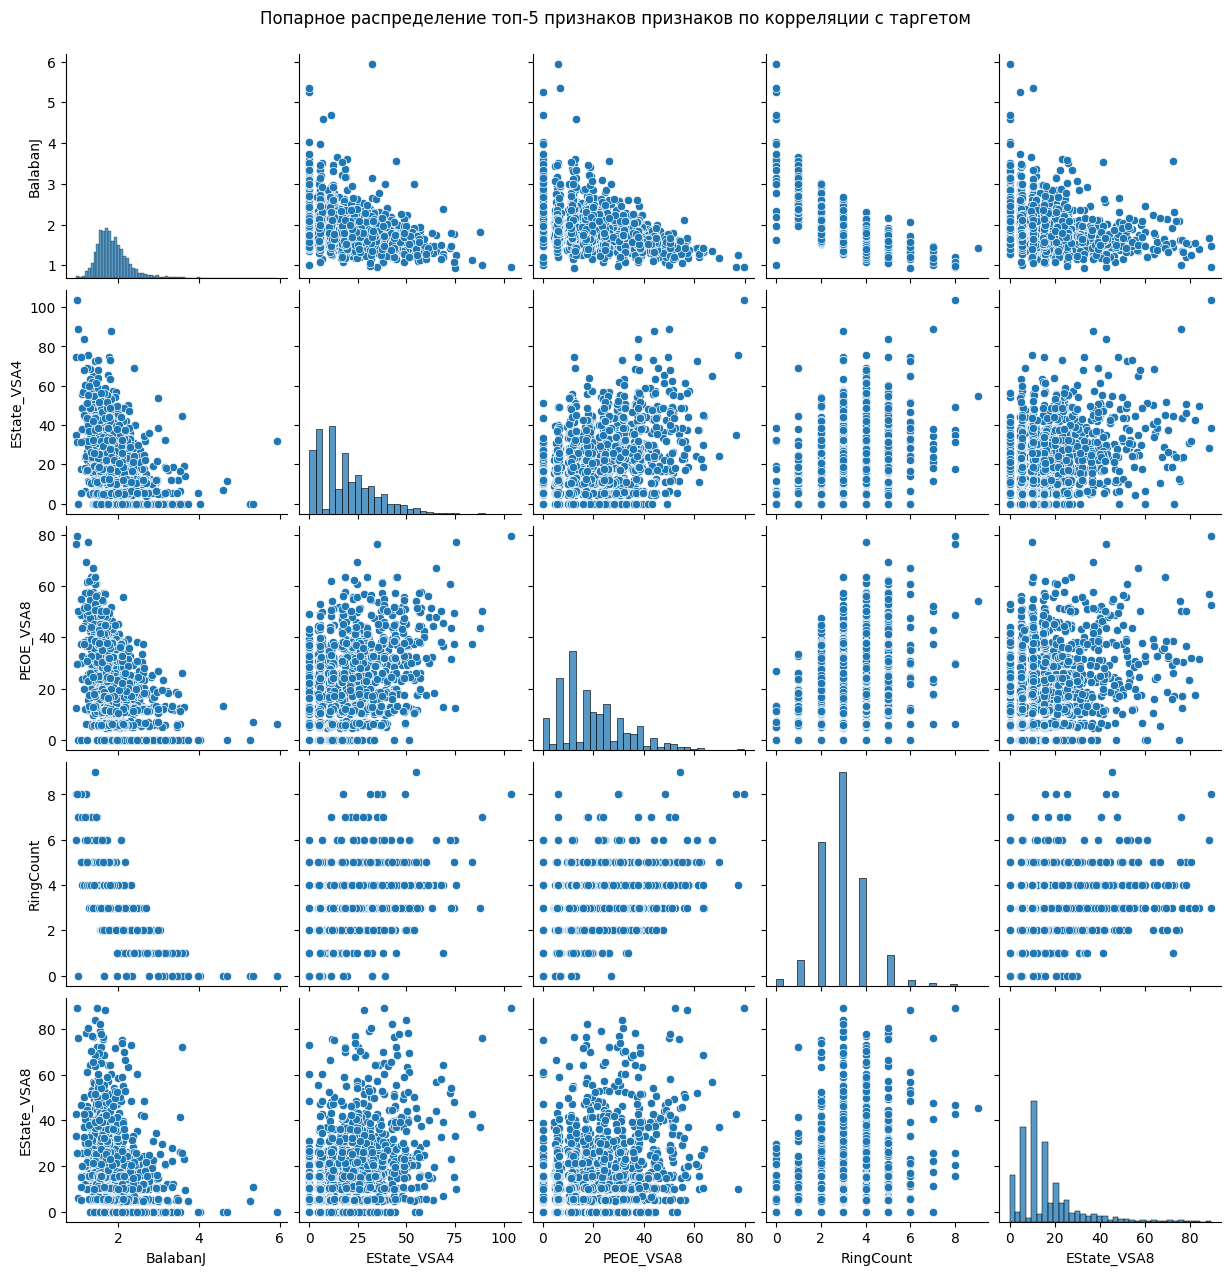

In [29]:
# Попарное распределение для финальных признаков
top_feats = corr_with_target.abs().max(axis=1).sort_values(ascending=False).head(5).index.tolist()
sample_df = eda_features_df[top_feats].sample(2000, random_state=42)

sns.pairplot(sample_df)
plt.suptitle("Попарное распределение топ-5 признаков признаков по корреляции с таргетом", y=1.02)
plt.show()